# Visual Perception Using Monocular Camera

This example shows how to construct a monocular camera sensor simulation to:
1. detect lane boundaries and backs of vehicles, and
2. report their locations in the vehicle coordinate system.

## Define Camera Configuration

Knowing the camera's intrinsic and extrinsic calibration parameters is critical to accurate conversion between pixel and vehicle coordinates.

1. Start by defining the camera's intrinsic parameters. The parameters below were determined earlier using a camera calibration procedure that used a checkerboard calibration pattern. You can use the cameraCalibrator app to obtain them for your camera. Note that the lens distortion coefficients were ignored, because there is little distortion in the data. The parameters are stored in a cameraIntrinsics object.

2. Next, define the camera orientation with respect to the vehicle's chassis. You will use this information to establish camera extrinsics that define the position of the 3-D camera coordinate system with respect to the vehicle coordinate system. The above quantities can be derived from the rotation and translation matrices returned by the extrinsics function. Pitch specifies the tilt of the camera from the horizontal position. For the camera used in this example, the roll and yaw of the sensor are both zero. 

3. The entire configuration defining the intrinsics and extrinsics is stored in the monoCamera object. Note that the monoCamera object sets up a very specific vehicle coordinate system, where the X-axis points forward from the vehicle and the Y-axis points to the left of the vehicle. The origin of the coordinate system is on the ground, directly below the camera center defined by the camera's focal point. Additionally, monoCamera provides imageToVehicle and vehicleToImage methods for converting between image and vehicle coordinate systems (assuming a flat road).

![vehicle_system](fig_vehicle_system.png)



In [1]:
focalLength    = [309.4362, 344.2161]; % [fx, fy] in pixel units
principalPoint = [318.9034, 257.5352]; % [cx, cy] optical center in pixel coordinates
imageSize      = [480, 640];           % [nrows, mcols]

camIntrinsics = cameraIntrinsics(focalLength, principalPoint, imageSize);

height = 2.1798;    % mounting height in meters from the ground
pitch  = 14;        % pitch of the camera in degrees

sensor = monoCamera(camIntrinsics, height, 'Pitch', pitch);

# Load a Frame of Video

Start by creating a VideoReader object that opens a video file. To be memory efficient, VideoReader loads one video frame at a time. Read an interesting frame that contains lane markers and a vehicle. 

Note: This example ignores lens distortion. If you were concerned about errors in distance measurements introduced by the lens distortion, at this point you would use the undistortImage function to remove the lens distortion.

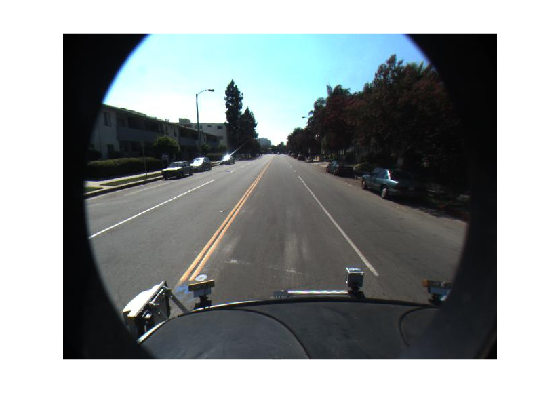

In [2]:
videoName = 'caltech_cordova1.avi';
videoReader = VideoReader(videoName);

timeStamp = 0.06667;                   % time from the beginning of the video
videoReader.CurrentTime = timeStamp;   % point to the chosen frame

frame = readFrame(videoReader); % read frame at timeStamp seconds
imshow(frame) % display frame

# Create Bird's-Eye-View Image

There are many ways to segment and detect lane markers. One approach involves the use of a bird's-eye-view image transform. Although it incurs computational cost, this transform offers one major advantage. The lane markers in the bird's-eye view are of uniform thickness, thus simplifying the segmentation process. The lane markers belonging to the same lane also become parallel, thus making further analysis easier.

Given the camera setup, the birdsEyeView object transforms the original image to the bird's-eye-view. It lets you specify the area that you want transformed using vehicle coordinates. Note that the vehicle coordinate units were established by the monoCamera object, when the camera mounting height was specified in meters. For example, if the height was specified in millimeters, the rest of the simulation would use millimeters.

The areas further away from the sensor are more blurry, due to having fewer pixels and thus requiring greater amount of interpolation.

Note that you can complete the latter processing steps without use of the bird's-eye view, as long as you can locate lane boundary candidate pixels in vehicle coordinates.

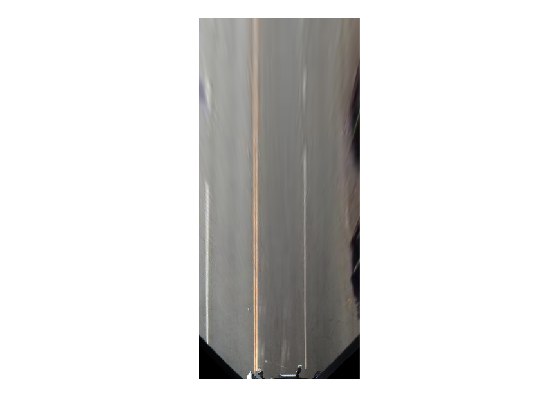

In [3]:
% Using vehicle coordinates, define area to transform
distAheadOfSensor = 30; % in meters, as previously specified in monoCamera height input
spaceToOneSide    = 6;  % all other distance quantities are also in meters
bottomOffset      = 3;

outView   = [bottomOffset, distAheadOfSensor, -spaceToOneSide, spaceToOneSide]; % [xmin, xmax, ymin, ymax]
imageSize = [NaN, 250]; % output image width in pixels; height is chosen automatically to preserve units per pixel ratio

birdsEyeConfig = birdsEyeView(sensor, outView, imageSize);

birdsEyeImage = transformImage(birdsEyeConfig, frame);
figure
imshow(birdsEyeImage)

# Find Lane Markers in Vehicle Coordinates

Having the bird's-eye-view image, you can now use the segmentLaneMarkerRidge function to separate lane marker candidate pixels from the road surface. This technique was chosen for its simplicity and relative effectiveness. Alternative segmentation techniques exist including semantic segmentation (deep learning) and steerable filters. You can be substitute these techniques below to obtain a binary mask needed for the next stage.

1. Most input parameters to the functions below are specified in world units, for example, the lane marker width fed into segmentLaneMarkerRidge. The use of world units allows you to easily try new sensors, even when the input image size changes. This is very important to making the design more robust and flexible with respect to changing camera hardware and handling varying standards across many countries.

2. Locating individual lane markers takes place in vehicle coordinates that are anchored to the camera sensor. This example uses a parabolic lane boundary model, ax^2 + bx + c, to represent the lane makers. Other representations, such as a third-degree polynomial or splines, are possible. Conversion to vehicle coordinates is necessary, otherwise lane marker curvature cannot be properly represented by a parabola while it is affected by a perspective distortion.

3. Since the segmented points contain many outliers that are not part of the actual lane markers, use the robust curve fitting algorithm based on random sample consensus (RANSAC). Return the boundaries and their parabola parameters (a, b, c) in an array of parabolicLaneBoundary objects, boundaries.

Notice that the findParabolicLaneBoundaries takes a function handle, validateBoundaryFcn. This example function is listed at the end of this example. Using this additional input lets you reject some curves based on the values of the a, b, c parameters. It can also be used to take advantage of temporal information over a series of frames by constraining future a, b, c values based on previous video frames.

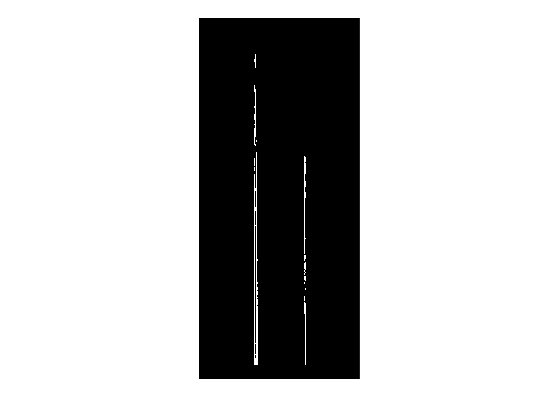

In [4]:
% Convert to grayscale
birdsEyeImage = rgb2gray(birdsEyeImage);

% Lane marker segmentation ROI in world units
vehicleROI = outView - [-1, 2, -3, 3]; % look 3 meters to left and right, and 4 meters ahead of the sensor
approxLaneMarkerWidthVehicle = 0.25; % 25 centimeters

% Detect lane features
laneSensitivity = 0.25;
birdsEyeViewBW = segmentLaneMarkerRidge(birdsEyeImage, birdsEyeConfig, approxLaneMarkerWidthVehicle,...
    'ROI', vehicleROI, 'Sensitivity', laneSensitivity);

figure
imshow(birdsEyeViewBW)

% Obtain lane candidate points in vehicle coordinates
[imageX, imageY] = find(birdsEyeViewBW);
xyBoundaryPoints = imageToVehicle(birdsEyeConfig, [imageY, imageX]);

maxLanes      = 2; % look for maximum of two lane markers
boundaryWidth = 3*approxLaneMarkerWidthVehicle; % expand boundary width to search for double markers

[boundaries, boundaryPoints] = findParabolicLaneBoundaries(xyBoundaryPoints,boundaryWidth, ...
    'MaxNumBoundaries', maxLanes, 'validateBoundaryFcn', @validateBoundaryFcn);

# Determine Boundaries of the Ego Lane

* Some of the curves found in the previous step might still be invalid. For example, when a curve is fit into crosswalk markers. Use additional heuristics to reject many such curves.

In [5]:
% Establish criteria for rejecting boundaries based on their length
maxPossibleXLength = diff(vehicleROI(1:2));
minXLength         = maxPossibleXLength * 0.60; % establish a threshold

% Reject short boundaries
isOfMinLength = arrayfun(@(b)diff(b.XExtent) > minXLength, boundaries);
boundaries    = boundaries(isOfMinLength);

* Remove additional boundaries based on the strength metric computed by the findParabolicLaneBoundaries function. Set a lane strength threshold based on ROI and image size.

In [7]:
% To compute the maximum strength, assume all image pixels within the ROI
% are lane candidate points
birdsImageROI = vehicleToImageROI(birdsEyeConfig, vehicleROI);
[laneImageX,laneImageY] = meshgrid(birdsImageROI(1):birdsImageROI(2),birdsImageROI(3):birdsImageROI(4));

% Convert the image points to vehicle points
vehiclePoints = imageToVehicle(birdsEyeConfig,[laneImageX(:),laneImageY(:)]);

% Find the maximum number of unique x-axis locations possible for any lane
% boundary
maxPointsInOneLane = numel(unique(vehiclePoints(:,1)));

% Set the maximum length of a lane boundary to the ROI length
maxLaneLength = diff(vehicleROI(1:2));

% Compute the maximum possible lane strength for this image size/ROI size
% specification
maxStrength   = maxPointsInOneLane/maxLaneLength;

% Reject weak boundaries
isStrong      = [boundaries.Strength] > 0.4*maxStrength;
boundaries    = boundaries(isStrong);

* The heuristics to classify lane marker type as single/double, solid/dashed are included in a helper function listed at the bottom of this example. Knowing the lane marker type is critical for steering the vehicle automatically. For example, passing another vehicle across double solid lane markers is prohibited.

In [8]:
boundaries = classifyLaneTypes(boundaries, boundaryPoints);

% Locate two ego lanes if they are present
xOffset    = 0;   %  0 meters from the sensor
distanceToBoundaries  = boundaries.computeBoundaryModel(xOffset);

% Find candidate ego boundaries
leftEgoBoundaryIndex  = [];
rightEgoBoundaryIndex = [];
minLDistance = min(distanceToBoundaries(distanceToBoundaries>0));
minRDistance = max(distanceToBoundaries(distanceToBoundaries<=0));
if ~isempty(minLDistance)
    leftEgoBoundaryIndex  = distanceToBoundaries == minLDistance;
end
if ~isempty(minRDistance)
    rightEgoBoundaryIndex = distanceToBoundaries == minRDistance;
end
leftEgoBoundary       = boundaries(leftEgoBoundaryIndex);
rightEgoBoundary      = boundaries(rightEgoBoundaryIndex);

* Show the detected lane markers in the bird's-eye-view image and in the regular view.

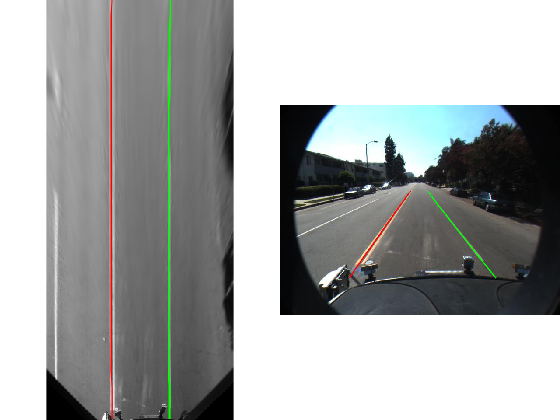

In [9]:
xVehiclePoints = bottomOffset:distAheadOfSensor;
birdsEyeWithEgoLane = insertLaneBoundary(birdsEyeImage, leftEgoBoundary , birdsEyeConfig, xVehiclePoints, 'Color','Red');
birdsEyeWithEgoLane = insertLaneBoundary(birdsEyeWithEgoLane, rightEgoBoundary, birdsEyeConfig, xVehiclePoints, 'Color','Green');

frameWithEgoLane = insertLaneBoundary(frame, leftEgoBoundary, sensor, xVehiclePoints, 'Color','Red');
frameWithEgoLane = insertLaneBoundary(frameWithEgoLane, rightEgoBoundary, sensor, xVehiclePoints, 'Color','Green');

figure
subplot('Position', [0, 0, 0.5, 1.0]) % [left, bottom, width, height] in normalized units
imshow(birdsEyeWithEgoLane)
subplot('Position', [0.5, 0, 0.5, 1.0])
imshow(frameWithEgoLane)

# Locate Vehicles in Vehicle Coordinates

Detecting and tracking vehicles is critical in front collision warning (FCW) and automated emergency braking (AEB) systems.

Load an aggregate channel features (ACF) detector that is pretrained to detect the front and rear of vehicles. A detector like this can handle scenarios where issuing a collision warning is important. It is not sufficient, for example, for detecting a vehicle traveling across a road in front of the ego vehicle.

Use the configureDetectorMonoCamera function to specialize the generic ACF detector to take into account the geometry of the typical automotive application. By passing in this camera configuration, this new detector searches only for vehicles along the road's surface, because there is no point searching for vehicles high above the vanishing point. This saves computational time and reduces the number of false positives.

Because this example shows how to process only a single frame for demonstration purposes, you cannot apply tracking on top of the raw detections. The addition of tracking makes the results of returning vehicle locations more robust, because even when the vehicle is partly occluded, the tracker continues to return the vehicle's location. For more information, see the Tracking Multiple Vehicles From a Camera example.

Next, convert vehicle detections to vehicle coordinates. The computeVehicleLocations function, included at the end of this example, calculates the location of a vehicle in vehicle coordinates given a bounding box returned by a detection algorithm in image coordinates. It returns the center location of the bottom of the bounding box in vehicle coordinates. Because we are using a monocular camera sensor and a simple homography, only distances along the surface of the road can be computed accurately. Computation of an arbitrary location in 3-D space requires use of stereo camera or another sensor capable of triangulation.

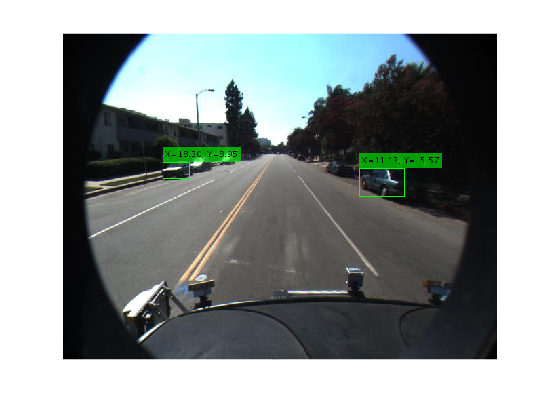

In [10]:
detector = vehicleDetectorACF();

% Width of a common vehicles is between 1.5 to 2.5 meters
vehicleWidth = [1.5, 2.5];

monoDetector = configureDetectorMonoCamera(detector, sensor, vehicleWidth);

[bboxes, scores] = detect(monoDetector, frame);

locations = computeVehicleLocations(bboxes, sensor);

% Overlay the detections on the video frame
imgOut = insertVehicleDetections(frame, locations, bboxes);
figure;
imshow(imgOut);

# Simulate a Complete Sensor with Video Input

Now that you have an idea about the inner workings of the individual steps, let's put them together and apply them to a video sequence where we can also take advantage of temporal information.

Rewind the video to the beginning, and then process the video. The code below is shortened because all the key parameters were defined in the previous steps. Here, the parameters are used without further explanation.

Display the video frame. Snapshot is taken at timeStamp seconds

In [11]:
videoReader.CurrentTime = 0;

isPlayerOpen = true;
snapshot     = [];
while hasFrame(videoReader) && isPlayerOpen

    % Grab a frame of video
    frame = readFrame(videoReader);

    % Compute birdsEyeView image
    birdsEyeImage = transformImage(birdsEyeConfig, frame);
    birdsEyeImage = rgb2gray(birdsEyeImage);

    % Detect lane boundary features
    birdsEyeViewBW = segmentLaneMarkerRidge(birdsEyeImage, birdsEyeConfig, ...
        approxLaneMarkerWidthVehicle, 'ROI', vehicleROI, ...
        'Sensitivity', laneSensitivity);

    % Obtain lane candidate points in vehicle coordinates
    [imageX, imageY] = find(birdsEyeViewBW);
    xyBoundaryPoints = imageToVehicle(birdsEyeConfig, [imageY, imageX]);

    % Find lane boundary candidates
    [boundaries, boundaryPoints] = findParabolicLaneBoundaries(xyBoundaryPoints,boundaryWidth, ...
        'MaxNumBoundaries', maxLanes, 'validateBoundaryFcn', @validateBoundaryFcn);

    % Reject boundaries based on their length and strength
    isOfMinLength = arrayfun(@(b)diff(b.XExtent) > minXLength, boundaries);
    boundaries    = boundaries(isOfMinLength);
    isStrong      = [boundaries.Strength] > 0.2*maxStrength;
    boundaries    = boundaries(isStrong);

    % Classify lane marker type
    boundaries = classifyLaneTypes(boundaries, boundaryPoints);

    % Find ego lanes
    xOffset    = 0;   %  0 meters from the sensor
    distanceToBoundaries  = boundaries.computeBoundaryModel(xOffset);
    % Find candidate ego boundaries
    leftEgoBoundaryIndex  = [];
    rightEgoBoundaryIndex = [];
    minLDistance = min(distanceToBoundaries(distanceToBoundaries>0));
    minRDistance = max(distanceToBoundaries(distanceToBoundaries<=0));
    if ~isempty(minLDistance)
        leftEgoBoundaryIndex  = distanceToBoundaries == minLDistance;
    end
    if ~isempty(minRDistance)
        rightEgoBoundaryIndex = distanceToBoundaries == minRDistance;
    end
    leftEgoBoundary       = boundaries(leftEgoBoundaryIndex);
    rightEgoBoundary      = boundaries(rightEgoBoundaryIndex);

    % Detect vehicles
    [bboxes, scores] = detect(monoDetector, frame);
    locations = computeVehicleLocations(bboxes, sensor);

    % Visualize sensor outputs and intermediate results. Pack the core
    % sensor outputs into a struct.
    sensorOut.leftEgoBoundary  = leftEgoBoundary;
    sensorOut.rightEgoBoundary = rightEgoBoundary;
    sensorOut.vehicleLocations = locations;

    sensorOut.xVehiclePoints   = bottomOffset:distAheadOfSensor;
    sensorOut.vehicleBoxes     = bboxes;

    % Pack additional visualization data, including intermediate results
    intOut.birdsEyeImage   = birdsEyeImage;
    intOut.birdsEyeConfig  = birdsEyeConfig;
    intOut.vehicleScores   = scores;
    intOut.vehicleROI      = vehicleROI;
    intOut.birdsEyeBW      = birdsEyeViewBW;

    closePlayers = ~hasFrame(videoReader);
    isPlayerOpen = visualizeSensorResults(frame, sensor, sensorOut, ...
        intOut, closePlayers);

    timeStamp = 7.5333; % take snapshot for publishing at timeStamp seconds
    if abs(videoReader.CurrentTime - timeStamp) < 0.01
        snapshot = takeSnapshot(frame, sensor, sensorOut);
    end
end

if ~isempty(snapshot)
    figure
    imshow(snapshot)
end

# Try the Sensor Design on a Different Video

The helperMonoSensor class assembles the setup and all the necessary steps to simulate the monocular camera sensor into a complete package that can be applied to any video. Since most parameters used by the sensor design are based on world units, the design is robust to changes in camera parameters, including the image size. Note that the code inside the helperMonoSensor class is different from the loop in the previous section, which was used to illustrate basic concepts.

Besides providing a new video, you must supply a camera configuration corresponding to that video. The process is shown here. Try it on your own videos.

Create the helperMonoSensor object and apply it to the video.

In [12]:
% Sensor configuration
focalLength    = [309.4362, 344.2161];
principalPoint = [318.9034, 257.5352];
imageSize      = [480, 640];
height         = 2.1798;    % mounting height in meters from the ground
pitch          = 14;        % pitch of the camera in degrees

camIntrinsics = cameraIntrinsics(focalLength, principalPoint, imageSize);
sensor        = monoCamera(camIntrinsics, height, 'Pitch', pitch);

videoReader = VideoReader('caltech_washington1.avi');

monoSensor   = helperMonoSensor(sensor);
monoSensor.LaneXExtentThreshold = 0.5;
% To remove false detections from shadows in this video, we only return
% vehicle detections with higher scores.
monoSensor.VehicleDetectionThreshold = 20;

isPlayerOpen = true;
snapshot     = [];
while hasFrame(videoReader) && isPlayerOpen

    frame = readFrame(videoReader); % get a frame

    sensorOut = processFrame(monoSensor, frame);

    closePlayers = ~hasFrame(videoReader);

    isPlayerOpen = displaySensorOutputs(monoSensor, frame, sensorOut, closePlayers);

    timeStamp = 11.1333; % take snapshot for publishing at timeStamp seconds
    if abs(videoReader.CurrentTime - timeStamp) < 0.01
        snapshot = takeSnapshot(frame, sensor, sensorOut);
    end

end

if ~isempty(snapshot)
    figure
    imshow(snapshot)
end